In [1]:
pip install ortools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from collections import defaultdict
from ortools.sat.python import cp_model
import ortools
import time

load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\rafae\OneDrive\Área de Trabalho\UPE\hugo\.venv\Lib\site-packages\ortools\.libs\ortools.dll...


##Empresa de Consultoria

In [3]:
#Organizamos os profissionais e suas funções em um dataset para auxiliar a extração das informações.#
df = pd.read_excel("./data/data_frame_summary/colaborators_data.xlsx")

In [4]:
#Essas são as especificações dos projetos. Optamos por testar 3 projetos.#
aux = [
[1,2,1,1,2],
[1,1,2,1,1],
[1,1,1,1,0]
]

Requisitos_Projetos = defaultdict(list)
for t in range(len(aux)):
  Requisitos_Projetos[t] = defaultdict(list)

for t in range(len(Requisitos_Projetos)):
  for j in range(len(set(df["Funcoes_Num"]))):
    Requisitos_Projetos[t][j] = aux[t][j]

Requisitos_Projetos

defaultdict(list,
            {0: defaultdict(list, {0: 1, 1: 2, 2: 1, 3: 1, 4: 2}),
             1: defaultdict(list, {0: 1, 1: 1, 2: 2, 3: 1, 4: 1}),
             2: defaultdict(list, {0: 1, 1: 1, 2: 1, 3: 1, 4: 0})})

In [5]:
performances_sum = []
for value in df["Performance"].values:
    for value2 in df["Performance"].values:
        performances_sum.append((value + value2) // 2)
Max_Performance = sum(performances_sum)
print(Max_Performance)

2801


In [6]:
Performance = defaultdict(list)
for i in range(len(df["Performance"].values)):
  aux = []
  for k in range(len(df["Performance"].values)):
    if i == k:
      aux.append(df["Performance"].values[i])
    else:
      aux.append((df["Performance"].values[i] + df["Performance"].values[k])//2)
  Performance[i] = aux
print("Performance[0]")
print(Performance[0])

Performance[0]
[np.int64(9), np.int64(7), np.int64(8), np.int64(8), np.int64(9), np.int64(8), np.int64(9), np.int64(8), np.int64(8), np.int64(9), np.int64(8), np.int64(9), np.int64(7), np.int64(7), np.int64(9), np.int64(7), np.int64(6), np.int64(6), np.int64(8), np.int64(8)]


##Otimização

Vamos criar um modelo baseado em Programação Linear Inteira (ILP).
Utilizaremos uma abordagem de Programação por Restrições (COP) para resolver o problema de alocação de recursos com maximização da sinergia.

In [7]:
#Primeiro crio meu extrator de informações do solver#
#*DONE criado uma classe para extrair as informações do solver*# no projeto principal
class VarArrayAndObjectiveSolutionPrinter(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables, limit):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.__solution_limit = limit
        self.solution_list = []
        self.solution_time = []
        self.solution_objective = []
        self.best_bound = 0
        self.__start_time = time.time()
    def on_solution_callback(self):
        self.__solution_count += 1
        if self.__solution_count >= self.__solution_limit:
            self.StopSearch()
        self.solution_list.append([self.Value(v) for v in self.__variables])
        current_time = time.time()
        obj = self.ObjectiveValue()
        self.best_bound = self.BestObjectiveBound()
        self.solution_time.append(current_time - self.__start_time)
        self.solution_objective.append(obj)
        #print('Solution %i, time = %0.2f s, objective = %i' %
        #      (self.__solution_count, current_time - self.__start_time, obj))
        #for v in self.__variables:
        #    print('  %s = %i' % (v, self.Value(v)), end=' ')
    def solution_count(self):
        return self.__solution_count

In [8]:
tic = time.time()#
model = cp_model.CpModel()
COP_iterations = 100
max_runtime = 60*10 #Critério de parada temporal#

#B será uma matriz binária. Para cada projeto i, cada colaborador j Bij=1 se ele participa de i, Bij=0 caso contrário#
B = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux1.append(model.NewBoolVar(f'B_{i}_{j}'))
  B.append(aux1)

#P será uma matriz binária de profissões. Para cada projeto i, uma profissão k pode ou não ser adequada ao colaborador j,
#tal que Pikj=1 quando houver aderência entre o profissional, sua profissão e a demanda do projeto, ou Pikj=0 caso contrário#
P = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for k in range(len(Requisitos_Projetos[i])):
    aux2 = []
    for j in range(len(df['Funcoes_Num'])):
      aux2.append(model.NewBoolVar(f'P_{i}_{k}_{j}'))
    aux1.append(aux2)
  P.append(aux1)

#S será uma matriz inteira. Cada projeto i receberá a Performance correspondente à atribuição do time#
S = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux2 = []
    for t in range(len(df['Funcoes_Num'])):
      aux2.append(model.NewIntVar(0, Max_Performance, f'S_{i}_{j}_{t}'))
    aux1.append(aux2)
  S.append(aux1)

#Restrição 1: #
#Nenhum profissional pode ser alocado em mais de 2 projetos#
for j in range(len(df['Funcoes_Num'])):
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) <= 2)

#Restrição 2: #
#Cada projeto não pode receber a atribuição de um número diferente de profissionais que o pré-determinado para cada função#
for i in range(len(Requisitos_Projetos)):
  for k in range(len(Requisitos_Projetos[i])):
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for j in range(len(df['Funcoes_Num']))]) == Requisitos_Projetos[i][k])

#Restrições 3, 4 e 5: #
#Garanto que um profissional não tenha sobrecarga caso outro com mesma função esteja ocioso#
for j in range(len(df['Funcoes_Num'])):
  x_var = model.NewBoolVar(f'x_var_{j}')
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) >= 1).OnlyEnforceIf(x_var)
  model.Add(cp_model.LinearExpr.Sum([B[i][j] for i in range(len(Requisitos_Projetos))]) == 0).OnlyEnforceIf(x_var.Not())
  for t in range(len(df['Funcoes_Num'])):
    if df['Funcoes_Num'][j] == df['Funcoes_Num'][t] and j != t:
      model.Add(cp_model.LinearExpr.Sum([B[i][t] for i in range(len(Requisitos_Projetos))]) <= 1).OnlyEnforceIf(x_var.Not())

#Restrições 6 e 7: #
#Determino uma conexão entre as variáveis Bij com Pikj#
for i in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for k in range(len(Requisitos_Projetos[i]))]) == 1).OnlyEnforceIf(B[i][j])
    model.Add(cp_model.LinearExpr.Sum([P[i][k][j] for k in range(len(Requisitos_Projetos[i]))]) == 0).OnlyEnforceIf(B[i][j].Not())

#Restrição 8: #
#Os profissionais atribuídos a cada função devem corresponder exatamente à expectativa dos cargos#
#Para definir esta restrição, primeiro devemos criar uma variável auxiliar booleana z_var#
#z_var = 1 quando uma dada função é desejada em um projeto, ou z_var = 0 caso contrário#
#Mais adiante, forçamos que B[i][j] > 0 somente quando z_var = 1#
for i in range(len(Requisitos_Projetos)):
  for k in range(len(Requisitos_Projetos[i])):
    for j in range(len(df['Funcoes_Num'])):
      y_var = model.NewBoolVar(f'y_var_{i}_{k}_{j}')
      model.Add(k == df['Funcoes_Num'][j]).OnlyEnforceIf(y_var)
      model.Add(k != df['Funcoes_Num'][j]).OnlyEnforceIf(y_var.Not())
      model.Add(P[i][k][j] >= 0).OnlyEnforceIf(y_var)
      model.Add(P[i][k][j] == 0).OnlyEnforceIf(y_var.Not())


#Gostaria de computadar a similaridade somente daqueles funcionário atribuídos a um mesmo projeto#
#Entretanto, uma multiplicar B[i][j] x B[i][k] resultaria em um problema não linear, fora do espoco desejado#
#neste intuito, criamos uma variável s a ser otimizada, atendendo à nossa demandas sem multiplicar diretamente B1 x B2#
objective_terms = []
for i in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    aux_bool = model.NewBoolVar(f'constr_{i}_{j}')
    model.Add(B[i][j] == 1).OnlyEnforceIf(aux_bool)
    model.Add(B[i][j] == 0).OnlyEnforceIf(aux_bool.Not())
    for t in range(len(df['Funcoes_Num'])):
      aux_bool2 = model.NewBoolVar(f'constr_{i}_{t}')
      model.Add(B[i][t] == 1).OnlyEnforceIf(aux_bool2)
      model.Add(B[i][t] == 0).OnlyEnforceIf(aux_bool2.Not())
      if j != t:
        s = model.NewBoolVar(f's_{i}_{j}_{t}')
        model.AddBoolOr(aux_bool.Not(), aux_bool2.Not(), s)
        model.AddImplication(s, aux_bool)
        model.AddImplication(s, aux_bool2)
        objective_terms.append(int(Performance[j][t]*10/2) * s)
        model.Add(S[i][j][t] == int(Performance[j][t]*10/2)).OnlyEnforceIf(s)
        model.Add(S[i][j][t] == 0).OnlyEnforceIf(s.Not())
      #else:
      #  model.Add(S[i][j][t] == 0)

#Função objetivo que visa maximizar a sinergia em todos os projetos#
model.Maximize(cp_model.LinearExpr.Sum(objective_terms))
solver = cp_model.CpSolver()
solution_collector = VarArrayAndObjectiveSolutionPrinter([S[i][j][t] for i in range(len(Requisitos_Projetos)) for j in range(len(df['Funcoes_Num'])) for t in range(len(df['Funcoes_Num']))],
                                                         COP_iterations)
solver.parameters.max_time_in_seconds = max_runtime
solver.parameters.log_search_progress = True
#solver.parameters.num_search_workers = 1
solver.log_callback = print
status = solver.Solve(model, solution_collector)
solution_collector.solution_list
solution_collector.solution_time
solution_collector.solution_objective
#solver.parameters.exploit_best_solution = 130

tac = time.time()#
sec1 = tac - tic#
print('Time =',sec1)
print('Status =', solver.StatusName(status))
print('FO =', solver.ObjectiveValue())

B_Array = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux1.append(solver.Value(B[i][j]))
  B_Array.append(aux1)

S_Array = []
for i in range(len(Requisitos_Projetos)):
  aux1 = []
  for j in range(len(df['Funcoes_Num'])):
    aux2 = []
    for t in range(len(df['Funcoes_Num'])):
      aux2.append(int(solver.Value(S[i][j][t])/10))
    aux1.append(aux2)
  S_Array.append(aux1)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 600 log_search_progress: true
Setting number of workers to 12

Initial optimization model '': (model_fingerprint: 0x795eab69b4251ea4)
#Variables: 4'281 (#bools: 1'140 in objective)
  - 3'080 Booleans in [0,1]
  - 1'200 in [0,2801]
  - 1 constants in {1} 
#kBoolOr: 4'020 (#enforced: 2'880) (#literals: 6'000)
#kLinear1: 5'400 (#enforced: 5'400)
#kLinear3: 124 (#enforced: 104)
#kLinearN: 135 (#enforced: 120) (#terms: 900)

Starting presolve at 0.01s
  1.09e-03s  0.00e+00d  [DetectDominanceRelations] 
  2.31e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=4 #num_dual_strengthening=2 
  6.80e-05s  0.00e+00d  [operations_research::sat::CpModelPresolver::ExtractEncodingFromLinear] #potential_supersets=12 
  3.65e-04s  0.00e+00d  [operations_research::sat::CpModelPresolver::DetectDuplicateColumns] 
  1.29e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::DetectDuplicateC

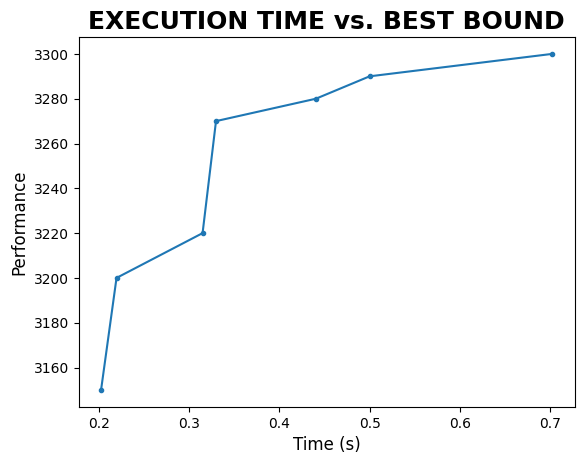

In [9]:
X= solution_collector.solution_time
Y= solution_collector.solution_objective

plt.scatter(X, Y, s=9)
plt.plot(X, Y)
plt.title("EXECUTION TIME vs. BEST BOUND", fontweight="bold", fontsize=18)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.show()

In [10]:
print('Número de Iterações:')
len(solution_collector.solution_objective)

Número de Iterações:


7

Validação de projetos e pessoas

In [11]:
Proj1, Proj2, Proj3 = [], [], []
for t in range(len(Requisitos_Projetos)):
  for j in range(len(df['Funcoes_Num'])):
    if t == 0:
      Proj1.append(B_Array[t][j])
    elif t == 1:
      Proj2.append(B_Array[t][j])
    else:
      Proj3.append(B_Array[t][j])

print(Proj1)
print(Proj2)
print(Proj3)

for projeto in [Proj1, Proj2, Proj3]:
  equipe = []
  for i in range(len(projeto)):
      if projeto[i]==1:
          equipe.append(df["Profissionais"][i])
  print('Equipe')
  print(equipe)

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Equipe
['João Ricardo', 'Diego Oliveira', 'Rildo Pereira', 'Luiz Gustavo Magoga', 'Rafael Calado', 'Katilce Delgado', 'Jorge Mariz']
Equipe
['Marcelo Eihara', 'Diego Oliveira', 'Alessandre Martins', 'Paulo Hugo', 'Leonides Neto', 'Rafael George']
Equipe
['Fabio Arnaldo', 'Washington Barbosa', 'Morgana Leite', 'Atahualpa Bastos']
